## Disaster Or Not?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("display.float", "{:.4f}".format)

%matplotlib inline
plt.style.use("fivethirtyeight")

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
print(f"TRAIN shape: {train.shape}")
print(f"TEST shape: {test.shape}")

TRAIN shape: (7613, 5)
TEST shape: (3263, 4)


# 1. Keyword and Location

In [6]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [8]:
missing_cols = ['keyword', 'location']

for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f"no_{col}")

In [10]:
print(f"Missing Values in TRAIN: {train.isna().sum().sum()}")
print(f"Missing Values in TEST: {test.isna().sum().sum()}")

Missing Values in TRAIN: 0
Missing Values in TEST: 0


In [11]:
print(f'Number of unique values in keyword = {train["keyword"].nunique()} (Training) - {test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {train["location"].nunique()} (Training) - {test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


# Feature Engineering

Create `word_count` and `unique_word_count`. The `word_count` shows how many words on the sentence and the `unique_word_count` shows how many unique words in the sentence.

In [12]:
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

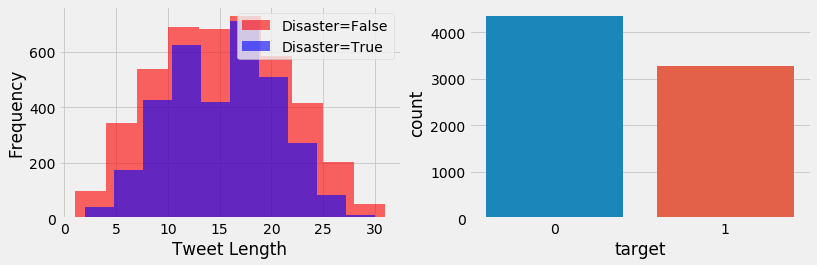

In [35]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
train[train.target==0].word_count.plot(kind='hist', color='red', 
                                       label='Disaster=False', alpha=0.6)
train[train.target==1].word_count.plot(kind='hist', color='blue', 
                                       label='Disaster=True', alpha=0.6)
plt.legend()
plt.xlabel("Tweet Length")

plt.subplot(2, 2, 2)
sns.countplot('target', data=train)

Remove stop words like and, or, the, a, ... As this word apairs in allmost all english sentences they will not help our model.

In [37]:
from wordcloud import STOPWORDS

train["clean_text"] = train.text.apply(lambda x: ' '.join([w for w in str(x).lower().split() 
                                                           if w not in STOPWORDS and w.isalpha()]))
test["clean_text"] = test.text.apply(lambda x: ' '.join([w for w in str(x).lower().split() 
                                                         if w not in STOPWORDS and w.isalpha()]))
train.head()

,id,keyword,location,text,target,word_count,unique_word_count,clean_text
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,deeds reason may allah forgive us
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,forest fire near la ronge canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,22,20,residents asked notified evacuation shelter pl...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,people receive evacuation orders california
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,got sent photo ruby smoke pours school


Now we will counts the apearance of each word in Disaster comment as well as in Non-Disaster comment.

In [41]:
from collections import Counter
count = Counter()
for row in train[train.target == 0].clean_text.str.split(' '):
    count.update(row)

In [42]:
count.most_common(15)

[('will', 177),
 ('new', 163),
 ('one', 116),
 ('now', 116),
 ('body', 106),
 ('via', 97),
 ('love', 85),
 ('got', 82),
 ('people', 81),
 ('full', 81),
 ('see', 79),
 ('know', 78),
 ('video', 76),
 ('back', 75),
 ('emergency', 75)]

In [43]:
count_1 = Counter()
for row in train[train.target == 1].clean_text.str.split(' '):
    count_1.update(row)

In [44]:
count_1.most_common(20)

[('fire', 151),
 ('via', 117),
 ('suicide', 103),
 ('disaster', 97),
 ('police', 94),
 ('people', 93),
 ('killed', 92),
 ('california', 88),
 ('families', 81),
 ('will', 77),
 ('two', 71),
 ('storm', 71),
 ('train', 71),
 ('bomb', 67),
 ('emergency', 66),
 ('crash', 65),
 ('one', 63),
 ('nuclear', 63),
 ('bombing', 63),
 ('news', 63)]

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X = train.drop(["text", "target"], axis=1)
y = train.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# cout_vect = CountVectorizer(ngram_range=(1, 2))
cout_vect = CountVectorizer()
X_train_text = cout_vect.fit_transform(X_train.clean_text)
X_test_text = cout_vect.transform(X_test.clean_text)

In [54]:
print(f"X_TRAIN shape: {X_train.shape}")
print(f"X_TEST shape: {X_test.shape}")

X_TRAIN shape: (5329, 9155)
X_TEST shape: (2284, 9155)


In [55]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [56]:
from sklearn.metrics import classification_report

y_pred = nb_model.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.8042,0.7787,0.7942,0.7914,0.7934
recall,0.8505,0.7174,0.7942,0.7840,0.7942
f1-score,0.8267,0.7468,0.7942,0.7867,0.7929
support,1318.0000,966.0000,0.7942,2284.0000,2284.0000


In [57]:
y_pred = nb_model.predict(X_train)
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.8919,0.9236,0.9045,0.9077,0.9056
recall,0.9464,0.8495,0.9045,0.8979,0.9045
f1-score,0.9183,0.8850,0.9045,0.9017,0.9039
support,3024.0000,2305.0000,0.9045,5329.0000,5329.0000
